<a href="https://colab.research.google.com/github/teticio/audio-diffusion/blob/master/notebooks/audio_diffusion_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Diffusion

In [ ]:
try:
    # are we running on Google Colab?
    import google.colab
    %pip install -q diffusers torch librosa datasets
except:
    pass

In [37]:
import torch
import random
import librosa
import numpy as np
from datasets import load_dataset
from IPython.display import Audio
from librosa.beat import beat_track
from diffusers import DiffusionPipeline
import cv2
from PIL import Image

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = torch.Generator(device=device)

## DDPM (De-noising Diffusion Probabilistic Models)

### Select model

In [18]:
#@markdown teticio/audio-diffusion-256                     - trained on my Spotify "liked" playlist

#@markdown teticio/audio-diffusion-breaks-256              - trained on samples used in music

#@markdown teticio/audio-diffusion-instrumental-hiphop-256 - trained on instrumental hiphop

#model_id = "teticio/audio-diffusion-256"  #@param ["teticio/audio-diffusion-256", "teticio/audio-diffusion-breaks-256", "audio-diffusion-instrumenal-hiphop-256", "teticio/audio-diffusion-ddim-256"]
model_id = "../../models/ddpm-ema-audio-128"

In [38]:
audio_diffusion = DiffusionPipeline.from_pretrained(model_id).to(device)
mel = audio_diffusion.mel
sample_rate = mel.get_sample_rate()

Loading pipeline components...: 100%|█████████████████████████████████████████████████████| 3/3 [00:00<00:00, 40.47it/s]


In [20]:
def loop_it(audio: np.ndarray,
        sample_rate: int,
        loops: int = 12) -> np.ndarray:
    """Loop audio

    Args:
        audio (np.ndarray): audio as numpy array
        sample_rate (int): sample rate of audio
        loops (int): number of times to loop

    Returns:
        (float, np.ndarray): sample rate and raw audio or None
    """
    _, beats = beat_track(y=audio, sr=sample_rate, units='samples')
    for beats_in_bar in [16, 12, 8, 4]:
        if len(beats) > beats_in_bar:
            return np.tile(audio[beats[0]:beats[beats_in_bar]], loops)
    return None

### Run model inference to generate mel spectrogram, audios and loops

Seed = 449375593288604


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 45.76it/s]


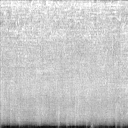

In [41]:
for _ in range(1):
    seed = generator.seed()
    print(f'Seed = {seed}')
    generator.manual_seed(seed)
    output = audio_diffusion(generator=generator)
    #print(type(output.images[0]))
    image = output.images[0] # Image.fromarray(cv2.pyrUp(cv2.pyrUp(np.array(output.images[0]))))
    audio = mel.image_to_audio(image) #output.audios[0, 0]
    display(image)
    display(Audio(audio, rate=sample_rate))
    loop = loop_it(audio, sample_rate)
    if loop is not None:
        display(Audio(loop, rate=sample_rate))
    else:
        print("Unable to determine loop points")